------------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#
class RBFnn:
    def __init__(self, input_size, neuron_num, output_size):
        self.L = output_size
        self.N = input_size
        self.M = neuron_num
        self.mu = np.random.random([input_size, neuron_num])
        self.sigma = np.ones([input_size, neuron_num])
        self.W = np.random.random([neuron_num, output_size])
        self.bias = np.zeros([1, output_size])

    def forward(self, x):
        phi = np.exp(-((np.expand_dims(x,-1)-np.expand_dims(self.mu,0))/np.expand_dims(self.sigma,0))**2)
        phi = phi.prod(1)
        self.phi = phi
        y_hat = phi @ self.W + self.bias
        return(y_hat)
    def grad(self, x, e):
        error1 = e 
        error = (np.expand_dims(self.W, 0)*np.expand_dims(error1, 1)).mean(-1)  # sample * neuron_num

        grad_W = (np.expand_dims(self.phi,-1)*np.expand_dims(error1, 1)).mean(0)

        grad_mu = (np.expand_dims(self.phi,1)*(np.expand_dims(x,-1)-np.expand_dims(self.mu,0))/np.expand_dims(self.sigma,0)**2)*np.expand_dims(error, 1)
        grad_mu = grad_mu.mean(0)

        grad_sigma = (np.expand_dims(self.phi,1)*(np.expand_dims(x,-1)-np.expand_dims(self.mu,0))**2/np.expand_dims(self.sigma,0)**3)*np.expand_dims(error, 1)
        grad_sigma = grad_sigma.mean(0)

        grad_bias = error1.mean(-1).mean(0)#*0

        grad_for_previous = -(np.expand_dims(self.phi,1)*(np.expand_dims(x,-1)-np.expand_dims(self.mu,0))/np.expand_dims(self.sigma,0)**2)*np.expand_dims(error, 1)
        grad_for_previous = grad_for_previous.sum(-1)
        return(grad_W, grad_mu, grad_sigma, grad_bias, grad_for_previous)
    def Train(self, x, e, learning_rate = 0.01):#e, Ac
        grad_W, grad_mu, grad_sigma, grad_bias, grad_for_previous = self.grad(x, e)#e, Ac
        self.W -= learning_rate * grad_W
        self.mu -= learning_rate * grad_mu
        self.sigma -= learning_rate * grad_sigma
        self.bias -= learning_rate * grad_bias
        # return grad_for_previous
            

In [2]:
import numpy as np

class Pendulum_Nonlinear_System:
    def __init__(self, dt = 0.01):
        self.y = np.array([0])
        self.Ac = -20*np.eye(2)
        self.dt = dt
        self.t = np.linspace(0, 15, int((15-0)/dt))
        self.x = np.array([[.5],[.5]])
        self.reference = np.sin(self.t)
    def step(self, u):
        self.x_dot = np.array([[self.x[1,0]], [-5*self.x[0,0]**3-2*self.x[1,0]+u]])
        self.x += self.x_dot * self.dt
        self.y = self.x[0]



##  Pendulum Nonlinear System

<img src="pendulum.png">

In [23]:
controller = RBFnn(input_size = 2, neuron_num = 1, output_size = 1)
observer = RBFnn(input_size = 2, neuron_num = 1, output_size = 1)

plant = Pendulum_Nonlinear_System()
history = {'y': [], 'y_observer': [], 'u':[]}
for i in range(len(plant.t)):
    input_ = np.array([[plant.y[0], plant.reference[i]]])

    u = controller.forward(input_)
    obs_input = np.hstack((plant.y.reshape([1,-1]), u))
    y_hat = observer.forward(obs_input)
    plant.step(u[0,0])

    ### Obs : RBF , Controller : RBF
    Loss_derivative_controller = (y_hat - plant.reference[i]).reshape([-1,1])#*10**(-3)
    loss_derivative_observer = y_hat - plant.y
    _, _, _, _, grad_for_previous = observer.grad(obs_input, Loss_derivative_controller)
    controller.Train(input_, grad_for_previous[:,plant.y.shape[0]:] + .01*u, learning_rate=.1*.7)

    observer.Train(obs_input, loss_derivative_observer*.1 , learning_rate=1)# Loss_derivative_controller
    
    history['y'].append(plant.y[0])
    history['y_observer'] .append(y_hat[0])
    history['u'].append(u[0,0])
    


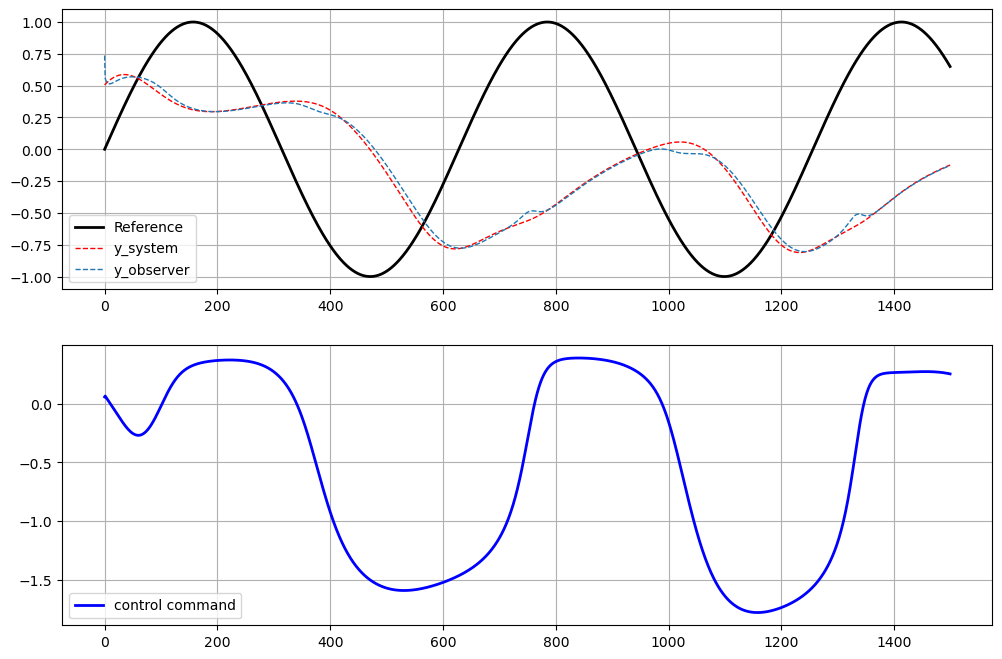

In [24]:
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(plant.reference, 'k-', linewidth = 2)
plt.plot(history['y'], 'r--', linewidth = 1)
plt.plot(history['y_observer'], '--', linewidth = 1)
plt.legend(['Reference', 'y_system', 'y_observer'])
plt.grid('on')

plt.subplot(2,1,2)
plt.plot(history['u'], 'b-', label='control command', linewidth = 2)
plt.grid('on')
plt.legend()
